In [214]:
import pandas as pd
import matplotlib.pyplot as plt
from myutils import (
    get_rolling_kelly, process_data, get_historical_var, calculate_daily_rf,
    get_cumulative_trix_returns, calculate_trix
)

sp500 = pd.read_csv('SP500_mine.csv')
sp500 = process_data(sp500)

In [215]:
var_confidence = 0.5
window = 400

In [216]:
# ema = 이동평균, ewm: 이동평균 구하는 함수
def calculate_trix(close_prices, n):
    ema1 = close_prices.ewm(span=n, min_periods=n).mean()
    ema2 = ema1.ewm(span=n, min_periods=n).mean()
    ema3 = ema2.ewm(span=n, min_periods=n).mean()
    
    trix = (ema3 - ema3.shift(1)) / ema3.shift(1) * 100
    return trix

In [217]:
sp500['trix'] = calculate_trix(sp500['Price'], n=5)
sp500['buy_signal'] = False
sp500['sell_signal'] = False
sp500['trix'] = sp500['trix'].fillna(0)

In [218]:
# 조건에 따라 buy_signal 및 sell_signal 설정
for i in range(1, len(sp500)):
    if sp500.iloc[i]['trix'] < 0 and sp500.iloc[i-1]['trix'] > 0:
        sp500.at[sp500.index[i], 'buy_signal'] = True
    elif sp500.iloc[i]['trix'] > 0 and sp500.iloc[i-1]['trix'] < 0:
        sp500.at[sp500.index[i], 'sell_signal'] = True

In [219]:
# # 매수/매도 신호 감지
# buy_signals = sp500['trix'].diff() > 0
# sell_signals = sp500['trix'].diff() < 0

# # buy_signals과 sell_signals을 사용하여 sp500 DataFrame에 각각 buy_signal과 sell_signal 열 추가
# sp500['buy_signal'] = buy_signals
# sp500['sell_signal'] = sell_signals

# # 매수 신호에 해당하는 행만 선택
# buy_signals = sp500[sp500['buy_signal']]
# sp500.head(30)

In [220]:
sp500[sp500['trix'].isna()]

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal
Date,,,,,,,,,


### 이전 과정 동일 수행

In [221]:
# rf 추가
rf = pd.read_csv('rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
sp500 = sp500.join(rf)
sp500['rf'] = sp500['rf'].ffill()

In [222]:
# VaR 계산
sp500_var = get_historical_var(sp500, window, var_confidence)

In [223]:
# Kelly 계산
rolling_kelly = get_rolling_kelly(sp500_var)
sp500_var['kelly'] = rolling_kelly

In [224]:
# 정해둔 시점에 대한 값만 겟
index_location = sp500_var.index.get_loc('01/08/2009')
sp500_target = sp500_var.iloc[index_location+1:]

In [225]:
sp500_target[sp500_target['kelly'] < 0]

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly
Date,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.254039,False,False,0.000097,0.0001,-2.466456
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,-0.002912,True,False,0.000093,0.0001,-2.515697
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,-0.206286,False,False,0.000091,0.0001,-2.584317
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,-0.454181,False,False,0.000091,0.0001,-2.770916
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,-0.631876,False,False,0.000093,0.0001,-2.803653
...,...,...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0004,-0.867260
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0004,-0.607260
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0003,-0.416157


<Axes: xlabel='Date'>

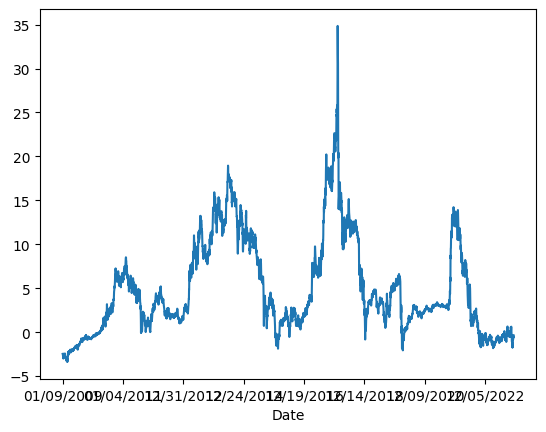

In [226]:
sp500_target['kelly'].plot()

In [227]:
# sp500_target['kelly_ratio'] = sp500_target['kelly'] / 100
sp500_target['kelly_ratio'] = sp500_target['kelly']
sp500_target['kelly_ratio'] = sp500_target['kelly_ratio'].apply(lambda x: x if x < 5 else 5)

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_5178/2926833342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['kelly_ratio'] = sp500_target['kelly']
/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_5178/2926833342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['kelly_ratio'] = sp500_target['kelly_ratio'].apply(lambda x: x if x < 5 else 5)


In [228]:
sp500_zero_kelly = sp500_target.copy()
sp500_zero_kelly['kelly_ratio'] = sp500_zero_kelly['kelly_ratio'].apply(lambda x: x if x>0 else 0)

In [229]:
sp500_zero_kelly.head(5)

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio
Date,,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.254039,False,False,0.000097,0.0001,-2.466456,0.0
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,-0.002912,True,False,0.000093,0.0001,-2.515697,0.0
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,-0.206286,False,False,0.000091,0.0001,-2.584317,0.0
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,-0.454181,False,False,0.000091,0.0001,-2.770916,0.0
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,-0.631876,False,False,0.000093,0.0001,-2.803653,0.0


In [230]:
sp500_result_var_kelly = sp500_zero_kelly.copy()
sp500_result_var_kelly['check'] = (sp500_result_var_kelly['Change'] - sp500_result_var_kelly['trix'])/(100 * abs(sp500_result_var_kelly['Change']))
sp500_result_var_kelly

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio,check
Date,,,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.254039,False,False,0.000097,0.0001,-2.466456,0.0,-0.129267
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,-0.002912,True,False,0.000093,0.0001,-2.515697,0.0,-0.008712
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,-0.206286,False,False,0.000091,0.0001,-2.584317,0.0,1.156032
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,-0.454181,False,False,0.000091,0.0001,-2.770916,0.0,0.125576
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,-0.631876,False,False,0.000093,0.0001,-2.803653,0.0,4.870585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0004,-0.867260,0.0,-1.605002
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0004,-0.607260,0.0,-1.363939
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0003,-0.416157,0.0,-4.266175


In [231]:
def update_kelly(row):
    if row['VaR'] >= row['Change']:
        return 0
    else:
        return row['kelly_ratio']

sp500_result_var_kelly['kelly_ratio'] = sp500_result_var_kelly.apply(lambda row: update_kelly(row), axis=1)

In [232]:
sp500_result = get_cumulative_trix_returns(sp500_target)
sp500_result_zero_kelly = get_cumulative_trix_returns(sp500_zero_kelly)
sp500_result_var_kelly = get_cumulative_trix_returns(sp500_result_var_kelly)

/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'portfolio'] = portfolio
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'equity'] = equity
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [233]:
sp500_result_zero_kelly.to_csv('확인.csv')

In [234]:
1.0252**4

1.104674655307801

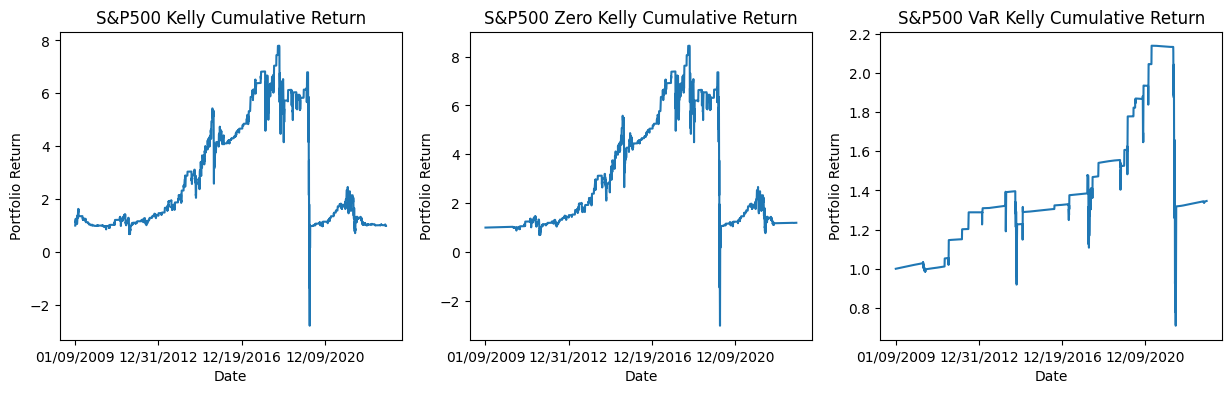

In [235]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

sp500_result['portfolio'].plot(ax=ax[0])
ax[0].set_ylabel('Portfolio Return');
ax[0].set_title('S&P500 Kelly Cumulative Return');

sp500_result_zero_kelly['portfolio'].plot(ax=ax[1])
ax[1].set_ylabel('Portfolio Return');
ax[1].set_title('S&P500 Zero Kelly Cumulative Return');

sp500_result_var_kelly['portfolio'].plot(ax=ax[2])
ax[2].set_ylabel('Portfolio Return');
ax[2].set_title('S&P500 VaR Kelly Cumulative Return');


plt.savefig(f'trix_result/Returns:  var_{str(var_confidence)}, window_{str(window)}.png')

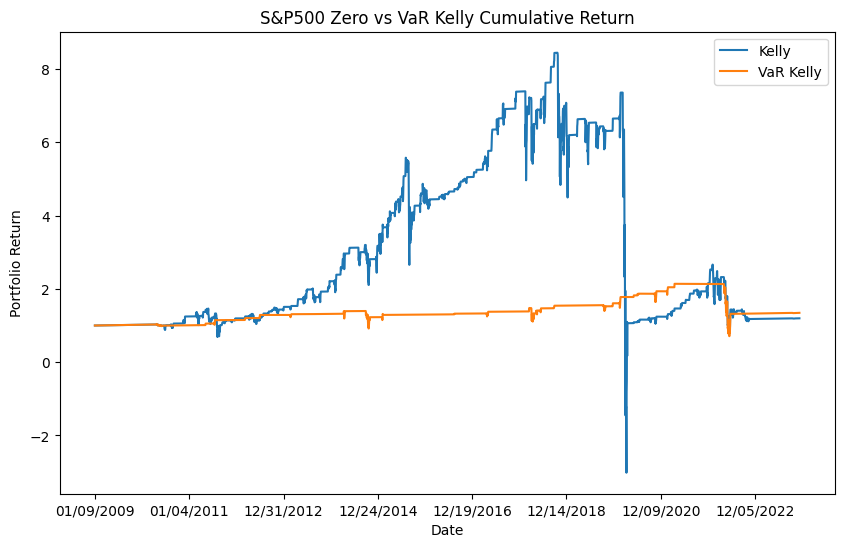

In [236]:
fig, ax = plt.subplots(figsize=(10, 6))

sp500_result_zero_kelly['portfolio'].plot(ax=ax, label='Kelly')
sp500_result_var_kelly['portfolio'].plot(ax=ax, label='VaR Kelly')

ax.set_ylabel('Portfolio Return')
ax.set_title('S&P500 Zero vs VaR Kelly Cumulative Return')
ax.legend()

plt.savefig(f'trix_result/Combined_Returns_var_{str(var_confidence)}_window_{str(window)}.png')